In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
# Load the ICD-9 procedures dictionary
procedures = pd.read_csv('D_ICD_PROCEDURES.csv.gz')

# Preview the dataset
procedures.head(30)

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,264,851,Canthotomy,Canthotomy
1,265,852,Blepharorrhaphy,Blepharorrhaphy
2,266,859,Adjust lid position NEC,Other adjustment of lid position
3,267,861,Lid reconst w skin graft,Reconstruction of eyelid with skin flap or graft
4,268,862,Lid reconst w muc graft,Reconstruction of eyelid with mucous membrane ...
5,269,863,Lid reconst w hair graft,Reconstruction of eyelid with hair follicle graft
6,270,864,Lid recon-tarsoconj flap,Reconstruction of eyelid with tarsoconjunctiva...
7,271,869,Lid reconstr w graft NEC,Other reconstruction of eyelid with flaps or g...
8,272,870,Lid reconstruction NOS,"Reconstruction of eyelid, not otherwise specified"
9,273,871,Lid marg recon-part thic,"Reconstruction of eyelid involving lid margin,..."


In [7]:
# Check datatypes and nulls
procedures.info()
missing = procedures.isnull().sum()
print(missing[missing > 0])

# Check and drop duplicates
print(f"Total duplicate rows: {procedures.duplicated().sum()}")
procedures.drop_duplicates(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3882 entries, 0 to 3881
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       3882 non-null   int64 
 1   ICD9_CODE    3882 non-null   int64 
 2   SHORT_TITLE  3882 non-null   object
 3   LONG_TITLE   3882 non-null   object
dtypes: int64(2), object(2)
memory usage: 121.4+ KB
Series([], dtype: int64)
Total duplicate rows: 0


In [8]:
# Encode SHORT_TITLE and LONG_TITLE
procedures['SHORT_TITLE_CAT'] = procedures['SHORT_TITLE'].astype('category').cat.codes
procedures['LONG_TITLE_CAT'] = procedures['LONG_TITLE'].astype('category').cat.codes


In [9]:
procedures_cleaned = procedures.copy()
procedures_cleaned.to_csv('procedures_cleaned.csv', index=False)


In [10]:
!pip install sdv
import sdv
print(sdv.__version__)



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
1.24.1


In [12]:
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

# Fix multiprocessing
os.environ["NUMBA_NUM_THREADS"] = "1"
os.environ["JOBLIB_START_METHOD"] = "spawn"

# Reload cleaned data
procedures_cleaned = pd.read_csv('procedures_cleaned.csv')

# Metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(procedures_cleaned)

# Synthesizer
synthesizer = CTGANSynthesizer(metadata=metadata, epochs=30)
synthesizer.fit(procedures_cleaned)


PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name   Est # of Columns (CTGAN)
ICD9_CODE              11
SHORT_TITLE            3882
LONG_TITLE             3882
SHORT_TITLE_CAT        11
LONG_TITLE_CAT         11

We recommend preprocessing discrete columns that can have many values, using 'update_transformers'. Or you may drop columns that are not necessary to model. (Exit this script using ctrl-C)


In [13]:
synthetic_data = synthesizer.sample(num_rows=1000)
synthetic_data.to_csv('synthetic_procedures.csv', index=False)
synthetic_data.head()


,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE,SHORT_TITLE_CAT,LONG_TITLE_CAT
0,9157262,8630,Opn ind ing hern-gft NEC,Osteoplasty [osteotomy] of body of mandible,1948,2424
1,5826993,9999,Tonsil/adenoid ops NEC,"Bone graft, scapula, clavicle, and thorax [rib...",3542,3474
2,3850511,6268,Exten buccolabial/sulcus,Cyclodialysis,537,1309
3,13796094,8978,Unilat thyroid lobectomy,Suture of capsule or ligament of ankle and foot,2280,2916
4,4238217,9999,Intravascul imaging NOS,"Microscopic examination of specimen from eye, ...",1791,749


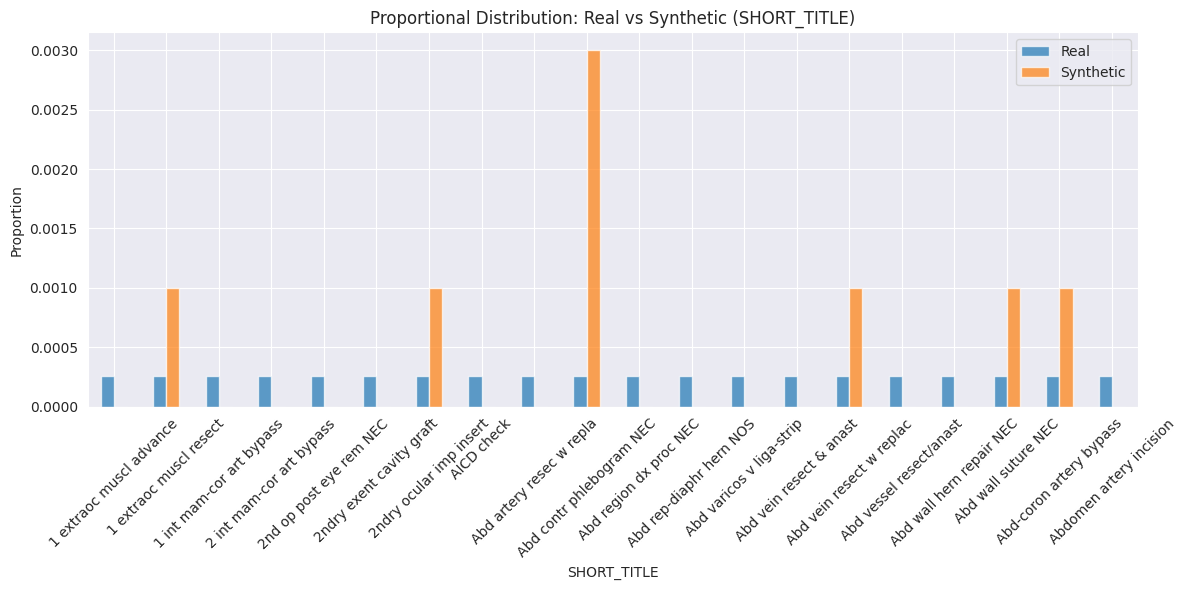

In [14]:
# Define the column you want to analyze
column = 'SHORT_TITLE'
# Calculate normalized value counts
real_counts = procedures_cleaned[column].value_counts(normalize=True)
synth_counts = synthetic_data[column].value_counts(normalize=True)

# Align both Series
df_compare = pd.DataFrame({'Real': real_counts, 'Synthetic': synth_counts}).fillna(0)
df_compare = df_compare.sort_values('Real', ascending=False).head(20)

# Plot
df_compare.plot(kind='bar', figsize=(12,6), alpha=0.7)
plt.title(f"Proportional Distribution: Real vs Synthetic ({column})")
plt.ylabel("Proportion")
plt.xlabel(column)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

features = ['SHORT_TITLE_CAT', 'LONG_TITLE_CAT']
target = 'ROW_ID'

# Create binary target
procedures_cleaned['target'] = (procedures_cleaned[target] > procedures_cleaned[target].median()).astype(int)
synthetic_data['target'] = (synthetic_data[target] > procedures_cleaned[target].median()).astype(int)

# Encode again just in case
for col in features:
    procedures_cleaned[col] = procedures_cleaned[col].astype('category').cat.codes
    synthetic_data[col] = synthetic_data[col].astype('category').cat.codes

# Real data
X_real = procedures_cleaned[features]
y_real = procedures_cleaned['target']
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3)

model_real = RandomForestClassifier()
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

# Synthetic data
X_syn = synthetic_data[features]
y_syn = synthetic_data['target']
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_syn, y_syn, test_size=0.3)

model_syn = RandomForestClassifier()
model_syn.fit(Xs_train, ys_train)
syn_acc = accuracy_score(ys_test, model_syn.predict(Xs_test))

print(f"\nModel accuracy on real PROCEDURES_ICD:     {real_acc:.2f}")
print(f"Model accuracy on synthetic PROCEDURES_ICD: {syn_acc:.2f}")



Model accuracy on real PROCEDURES_ICD:     0.73
Model accuracy on synthetic PROCEDURES_ICD: 1.00


In [16]:
from sdv.single_table import TVAESynthesizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define features and target (from D_CPT structure)
features = ['SHORT_TITLE_CAT', 'LONG_TITLE_CAT']
target_col = 'ROW_ID'

# Create binary classification target
procedures_cleaned['target'] = (procedures_cleaned[target_col] > procedures_cleaned[target_col].median()).astype(int)

# Regenerate metadata (if needed)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(procedures_cleaned.drop(columns=['target']))

# Fit TVAE (drop target column before fitting)
vae_synthesizer = TVAESynthesizer(metadata=metadata, epochs=30)
vae_synthesizer.fit(procedures_cleaned.drop(columns=['target']))

# Sample synthetic data
synthetic_data_vae = vae_synthesizer.sample(num_rows=1000)

# Add target to synthetic data
synthetic_data_vae['target'] = (synthetic_data_vae[target_col] > procedures_cleaned[target_col].median()).astype(int)

# Encode categorical features
for col in features:
    procedures_cleaned[col] = procedures_cleaned[col].astype('category').cat.codes
    synthetic_data_vae[col] = synthetic_data_vae[col].astype('category').cat.codes

# Train/test split
X_real = procedures_cleaned[features]
y_real = procedures_cleaned['target']
X_vae = synthetic_data_vae[features]
y_vae = synthetic_data_vae['target']

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3, random_state=42)
Xv_train, Xv_test, yv_train, yv_test = train_test_split(X_vae, y_vae, test_size=0.3, random_state=42)

# Train models
model_real = RandomForestClassifier(random_state=42)
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

model_vae = RandomForestClassifier(random_state=42)
model_vae.fit(Xv_train, yv_train)
vae_acc = accuracy_score(yv_test, model_vae.predict(Xv_test))

# Results
print(f"Model accuracy on REAL D_CPT data: {real_acc:.2f}")
print(f"Model accuracy on VAE SYNTHETIC D_CPT: {vae_acc:.2f}")


Model accuracy on REAL D_CPT data: 0.72
Model accuracy on VAE SYNTHETIC D_CPT: 1.00


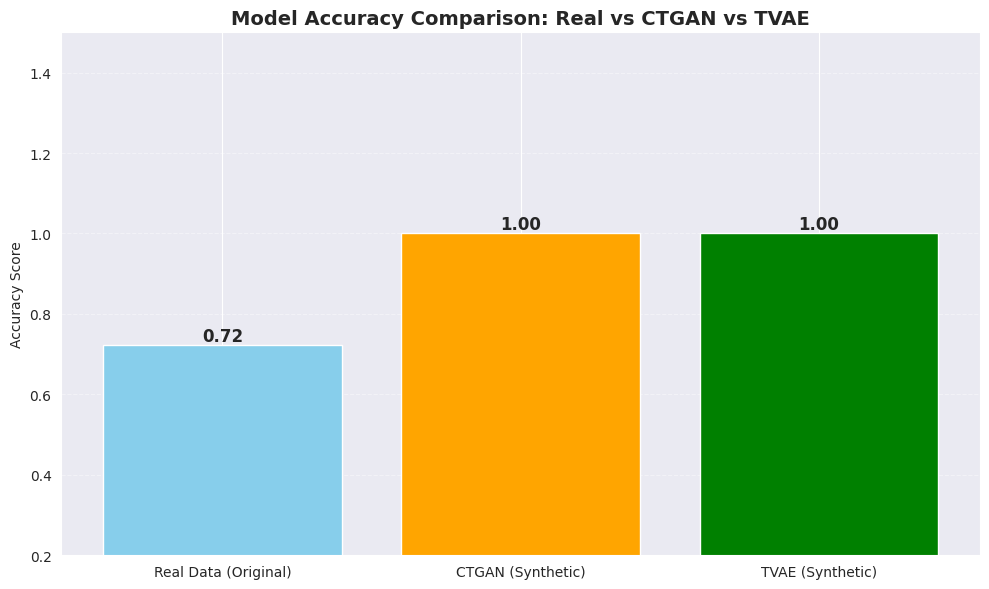

In [17]:
import matplotlib.pyplot as plt

#  accuracy values
# These are from your previous results:
real_acc = real_acc          # Accuracy on real data using real training
vae_acc = vae_acc           # Accuracy on synthetic VAE data
gan_acc = syn_acc           # Accuracy on synthetic GAN (CTGAN) data

# Prepare bar chart data
labels = ['Real Data (Original)', 'CTGAN (Synthetic)', 'TVAE (Synthetic)']
accuracy_scores = [real_acc, gan_acc, vae_acc]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracy_scores, color=['skyblue', 'orange', 'green'])

#  chart elements
plt.title('Model Accuracy Comparison: Real vs CTGAN vs TVAE', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Score')
plt.ylim(0.2, 1.5)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate bars
for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

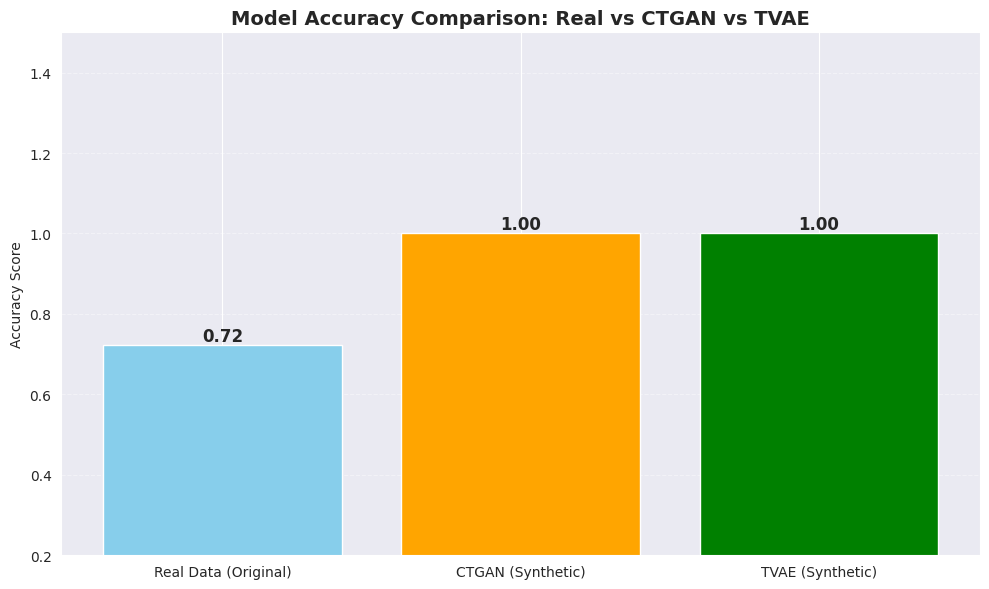

In [18]:
import matplotlib.pyplot as plt

#  accuracy values
# These are from your previous results:
real_acc = real_acc          # Accuracy on real data using real training
vae_acc = vae_acc           # Accuracy on synthetic VAE data
gan_acc = syn_acc           # Accuracy on synthetic GAN (CTGAN) data

# Prepare bar chart data
labels = ['Real Data (Original)', 'CTGAN (Synthetic)', 'TVAE (Synthetic)']
accuracy_scores = [real_acc, gan_acc, vae_acc]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracy_scores, color=['skyblue', 'orange', 'green'])

#  chart elements
plt.title('Model Accuracy Comparison: Real vs CTGAN vs TVAE', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Score')
plt.ylim(0.2, 1.5)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate bars
for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()